**Install libraries and load data**

In [1]:
!pip install tensorflow==2.12.0 librosa==0.9.1 numpy==1.22.4 matplotlib==3.7.1 scikit-learn==1.2.2 seaborn==0.12.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 117.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requir

**Download real audio data**
- The "Free Spoken Digit Dataset," which contains recordings of numbers spoken by a real human voice, is downloaded.
- It is copied to the dataset/real folder.

In [2]:
main_path_dataset = "/content/dataset"
real_voice_path = main_path_dataset+"/rale"
fake_voice_path = main_path_dataset+"/fake"

In [3]:
# Free Spoken Digit Dataset from GitHub
!git clone https://github.com/aaswaisi/Detecting-Deepfake-Audio-HMT-RAN.git

# Create the real/data folder and move the .wav files to it.
!mkdir -p dataset/real
!mkdir -p dataset/fake
!cp Detecting-Deepfake-Audio-HMT-RAN/dataset2/real/*.wav dataset/real/
!cp Detecting-Deepfake-Audio-HMT-RAN/dataset2/fake/*.wav dataset/fake/

Cloning into 'Detecting-Deepfake-Audio-HMT-RAN'...
remote: Enumerating objects: 7683, done.
remote: Total 7683 (delta 0), reused 0 (delta 0), pack-reused 7683 (from 1)
Receiving objects: 100% (7683/7683), 160.04 MiB | 20.73 MiB/s, done.
Resolving deltas: 100% (213/213), done.
Updating files: 100% (12000/12000), done.


**Create additional data using text-to-speech by using (gTTS)**
- Install libraries for text-to-speech (gTTS) and format conversion using ffmpeg.


In [4]:
!pip install gTTS pydub scipy --quiet
!apt-get install ffmpeg -y > /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.2 MB/s eta 0:00:00


For remove tree folder

In [12]:
#import shutil
#shutil.rmtree(main_path_dataset)

In [12]:
from gtts import gTTS
import os
import time
import random
from pydub import AudioSegment
from pydub.effects import speedup
import numpy as np

# Setting up paths
output_path = fake_voice_path
os.makedirs(output_path, exist_ok=True)

# General Settings
total_clips = 3000
numbers = list(range(1, 10))  # Generate number from number 1 to 9
clips_per_number = total_clips // len(numbers)
remainder = total_clips % len(numbers)

# Different dialects of gTTS
tld_choices = ['com', 'co.uk', 'com.au', 'ca', 'co.in']  # Provides audio diversity

# Change speed
def change_speed(audio, speed_factor):
    if speed_factor > 1:
        return speedup(audio, playback_speed=speed_factor)
    else:
        new_frame_rate = int(audio.frame_rate * speed_factor)
        return audio._spawn(audio.raw_data, overrides={'frame_rate': new_frame_rate}).set_frame_rate(audio.frame_rate)

# Add light noise
def add_noise(audio, noise_level_db=-30):
    duration = len(audio)
    noise = AudioSegment(
        (np.random.randn(int(audio.frame_rate * duration / 1000)) * 32767).astype(np.int16).tobytes(),
        frame_rate=audio.frame_rate,
        sample_width=2,
        channels=1
    )
    noise = noise - abs(noise_level_db)  # Reduce noise level
    return audio.overlay(noise)

# Generate audio file + process it
def safe_generate(num, index):
    try:
        tld = random.choice(tld_choices)
        tts = gTTS(text=str(num), lang='en', tld=tld)
        temp_wav = f"temp_{num}_{index}.wav"
        tts.save(temp_wav)

        audio = AudioSegment.from_mp3(temp_wav)

        # Change speed more widely
        speed = random.uniform(0.6, 1.4)
        audio = change_speed(audio, speed)

        # 50% chance of adding noise
        if random.random() < 0.5:
            noise_level = random.randint(-35, -25)
            audio = add_noise(audio, noise_level_db=noise_level)

        # Save the final file
        final_filename = os.path.join(output_path, f"{num}_{index}.wav")
        audio.export(final_filename, format="wav")

        os.remove(temp_wav)
        return True
    except Exception as e:
        print(f"Error in {num}_{index}: {str(e)}")
        return False

# Main generation
for num in numbers:
    extra = 1 if remainder > 0 else 0
    count_needed = clips_per_number + extra
    if remainder > 0:
        remainder -= 1

    success_count = 0
    index = 0
    while success_count < count_needed:
        index += 1
        if safe_generate(num, index):
            success_count += 1
            print(f"[{num}] Generated {success_count}/{count_needed}")
            time.sleep(random.uniform(0.5, 1))  # slight delay
        else:
            print("Wait 60 seconds before retrying...")
            time.sleep(60)

print("3000 fake audio clips were successfully generated in:", output_path)

Check the number of files

In [5]:
import os
def count_files_in_directory(directory_path):
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    return len(files)

real_voice_path = "/content/dataset/real"
fake_voice_path = "/content/dataset/fake"

print(f"Number of real voice files in the folder: {count_files_in_directory(real_voice_path)}")
print(f"Number of fake voice files in the folder: {count_files_in_directory(fake_voice_path)}")

Number of real voice files in the folder: 3000
Number of fake voice files in the folder: 3000


In [22]:
# These calls pave the way for writing classes for phonetic processing, and using the neural network model for training and evaluation.

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Constants
SAMPLE_RATE = 16000  # Resampled to 16kHz | Sample Rate represents the number of audio samples per second and is important: All audio is re-normalized to 16 kHz, which standardizes the input characteristics of the network.
DURATION = 4.0  # seconds (pad or trim to this length) | Standard length of each audio file and importance: Any audio clip will be exactly 4 seconds long (trimmed or added).
N_MFCC = 40  # Number of coefficients to represent MFCC and significance: MFCC reflects the spectral features that accurately represent human speech, and 40 is a common number for performance balance.
N_MELS = 128  # Number of Mel frequencies used in a spectrogram and their significance: Represents the energy density at different frequencies, and is used to extract the sound shape.
HOP_LENGTH = 512  # Hop length for STFT | The amount of time between frames when converting audio to a spectrogram determines how many times a frame is taken of the audio. Lower number = higher resolution.
MAX_FRAMES = int((SAMPLE_RATE * DURATION) / HOP_LENGTH) + 1 #Maximum number of frames that can be extracted from a 4-second audio clip and significance: Used to calculate the fixed input shape of the model (time × features).

# Configuration
config = {
    'batch_size': 32, # Number of samples in each training batch
    'epochs': 10, # Number of complete training cycles
    'learning_rate': 0.0001, # Model learning rate
    'transformer_layers': 5, # Number of Transformer layers
    'transformer_heads': 8, # Number of self-attention heads
    'transformer_dim': 256, # Representation size of each timestep
    'gru_units': 128, # Number of GRU units
    'dense_units': 128, # Number of final dense layer units
    'dropout_rate': 0.3, # Dropout ratio to reduce overfitting
    'l2_reg': 0.001, # L2 regularization to aid generalization
    'patience': 10 # Number of cycles without improvement before stopping training early
}

# Class AudioPreprocessor is responsible for preparing audio and converting it into a format suitable for training the model.
class AudioPreprocessor:
    def __init__(self, sample_rate=SAMPLE_RATE, duration=DURATION):
        self.sample_rate = sample_rate
        self.duration = duration
        # target_samples is the number of samples required (e.g. 16,000 x 4 = 64,000 samples per audio file).
        self.target_samples = int(sample_rate * duration)

    # This function for Load audio, remove silence, normalize values, and adjust length.
    def load_audio(self, file_path):
        """Load and preprocess audio file"""
        try:
            # Load audio file
            audio, sr = librosa.load(file_path, sr=self.sample_rate)

            # Remove silence
            audio = self._remove_silence(audio)

            # Normalize audio (Make it between -1 and 1).
            audio = self._normalize(audio)

            # Adjust length
            audio = self._adjust_length(audio)

            return audio
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None

    # Remove silent segments from audio
    # Removes audio parts that are lower than top_db (decibel level). Benefit: Reduces noise and improves data quality.
    def _remove_silence(self, audio, top_db=30):
        non_silent_intervals = librosa.effects.split(audio, top_db=top_db)
        audio_no_silence = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
        return audio_no_silence if len(audio_no_silence) > 0 else audio

    # Normalize audio to have zero mean and unit variance
    # Normalize the signal to have a mean of 0 and a standard deviation of 1. Benefit: Improve model performance and facilitate learning.
    def _normalize(self, audio):
        return (audio - np.mean(audio)) / (np.std(audio) + 1e-8)

    # Pad or trim audio to target length
    # Cut the audio if it is long, or add silence if it is short. The benefit: standardizes the length of all audio files.
    def _adjust_length(self, audio):
        if len(audio) > self.target_samples:
            # Trim
            audio = audio[:self.target_samples]
        elif len(audio) < self.target_samples:
            # Pad
            padding = self.target_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        return audio

    # Extract MFCC and Mel spectrogram features for each audio file
    # - MFCC: represents complex acoustic features.
    # - Mel: represents the energy density with a distribution close to that of human hearing.
    # The two are combined to form a feature matrix.
    def extract_features(self, audio):
        # MFCC features
        mfcc = librosa.feature.mfcc(
            y=audio, sr=self.sample_rate, n_mfcc=N_MFCC,
            n_fft=2048, hop_length=HOP_LENGTH
        )
        mfcc = mfcc.T  # Transpose to get time steps as first dimension

        # Mel spectrogram
        mel = librosa.feature.melspectrogram(
            y=audio, sr=self.sample_rate, n_mels=N_MELS,
            n_fft=2048, hop_length=HOP_LENGTH
        )
        mel = librosa.power_to_db(mel, ref=np.max)
        mel = mel.T  # Transpose to get time steps as first dimension

        # Stack features along the channel dimension
        features = np.concatenate([mfcc, mel], axis=-1)

        return features

This class "**MultiHeadSelfAttention**" implements the Multi-Head Self-Attention mechanism of the Transformer model. This class determines "what the model should pay attention to" in a time series (such as an audio clip). It allows for learning multiple relationships between different parts of the input.

In [23]:
class MultiHeadSelfAttention(layers.Layer):

    # embed_dim: Number of dimensions for the representation per time step.
    # num_heads: Number of attention heads (dividing the representation into multiple parts to focus on different aspects of the data).
    # projection_dim: Dimensions per head = embed_dim / num_heads
    # The network contains Dense layers to transform the input into: query, key, and value.
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    # attention: Calculating weights that determine how closely each time step relates to the next.
    # Steps:
    # - score: Multiply the dot between Q and K.
    # - scaled_score: Divided by the square root of the dimensions to minimize large values.
    # - softmax: Gives the weight to each correlation.
    # - output: Multiplying the weights by the value gives the final output.
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    # Splitting the representation into separate num_heads has the advantage: each head can learn a different type of temporal relationship.
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # run call: Converts the input to a query, key, and value.
    # Separates the heads, calculates the attention, recombines them (combine_heads), and produces:
    # Output: The attention-enhanced representation.
    # Weights: The attention weights (useful for later interpretation).
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)

        return output, weights

The class: "**TransformerBlock**" represents a complete unit of Transformer: (Multi-head attention + Feedforward + Normalization + Dropout).

In [24]:
class TransformerBlock(layers.Layer):

  # embed_dim: The size of the representation.
  # num_heads: The number of attention heads.
  # ff_dim: The size of the inner dense layer (usually larger).
  # dropout: To reduce overfitting.
  # l2_reg: To prevent overlearning of weights.

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, l2_reg=0.0001):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) # Attention layer
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu",
                        kernel_regularizer=regularizers.l2(l2_reg)),
            layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(l2_reg)),
        ]) # Small front grille (Dense-ReLU-Dense).
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6) # Helps stabilize values.
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate) # Overfitting reduces attention span and FFN.
        self.dropout2 = layers.Dropout(rate)

    # When the following function "Call" is run, the following will occur:
    # - Multi-head self-attention is calculated.
    # - Attention is added to the original input (residual connection).
    # - FFN + Dropout + another residual connection is applied.
    # - The final output and attention weights are returned.
    def call(self, inputs, training):
        attn_output, weights = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), weights

**Hybrid Multi-Level Transformer RNN Attention Network**
- It is the basic model, and combines several features:

**(Transformer + GRU + Attention + Dense Layers)**

**The overall goal of the class:**
- Input audio representations (such as MFCC + Mel).
- Pass them through Transformer layers to extract temporal context.
- Then, an RNN (GRU) layer is used to understand the sequence.
- Then, attention is applied at two levels: temporal and features.
- Finally, a classification layer (Sigmoid) is used to determine whether the audio is real or fake.

In [25]:
class HMT_RAN(tf.keras.Model):
    def __init__(self, config):
        super(HMT_RAN, self).__init__()
        self.config = config

        # Feature embedding
        # It transforms each time step (which represents the MFCC+Mel properties) into a high-dimensional representation which is necessary to prepare the data for entry into the Transformer.
        self.feature_embedding = layers.Dense(
            config['transformer_dim'],
            activation='relu',
            kernel_regularizer=regularizers.l2(config['l2_reg'])
        )

        # Positional encoding
        # Adds information about the order of the time steps (because Transformer doesn't understand order automatically) and uses (sin and cos) to generate a constant representation.
        self.positional_encoding = self._get_positional_encoding(
            MAX_FRAMES, config['transformer_dim'])

        # Transformer layers
        # A series of Transformer layers, each of which uses self-attention to understand the relationship between words or sounds over a long range.
        self.transformer_blocks = [
            TransformerBlock(
                config['transformer_dim'],
                config['transformer_heads'],
                config['transformer_dim'] * 4,
                config['dropout_rate'],
                config['l2_reg']
            ) for _ in range(config['transformer_layers'])
        ]

        # GRU layers
        # The GRU layer is bidirectional and is used to understand sequential information, capturing the "before and after" context of each time step.
        self.gru = layers.Bidirectional(
            layers.GRU(config['gru_units'], return_sequences=True)
        )

        # Multi-level attention
        # The idea: The model doesn't treat every time step equally.
        self.temporal_attention = layers.Attention(use_scale=True) # Determines which time step is more important.
        self.feature_attention = layers.Attention(use_scale=True) # Determines which audio feature is more influential.

        # Classification head
        # Fully connected layers are used post-processing to produce a single result:
        # 0 = Real audio
        # 1 = Fake audio
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(
            config['dense_units'],
            activation='relu',
            kernel_regularizer=regularizers.l2(config['l2_reg'])
        )
        self.dropout = layers.Dropout(config['dropout_rate'])
        self.dense2 = layers.Dense(1, activation='sigmoid')

        # Confidence score head
        # The degree of confidence of the model in a prediction is given and is useful for interpreting the decision.
        self.confidence_head = layers.Dense(1, activation='sigmoid')

    # The following function creates a constant matrix (position × dimension) and uses functions (sin and cos) to add to the representation of each time step so that it has a defined "position".
    def _get_positional_encoding(self, max_len, d_model):
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

        pos_enc = np.zeros((max_len, d_model))
        pos_enc[:, 0::2] = np.sin(position * div_term)
        pos_enc[:, 1::2] = np.cos(position * div_term)

        return tf.convert_to_tensor(pos_enc, dtype=tf.float32)

    def call(self, inputs, training=False, return_all=False):

        # Feature embedding
        # Converting inputs to a suitable representation for the Transformer
        x = self.feature_embedding(inputs)

        # Add positional encoding
        # Give each time step a "position"
        x += self.positional_encoding[:tf.shape(x)[1], :]

        # Transformer blocks
        # Extracting temporal relationships between data
        attention_weights = []
        for transformer_block in self.transformer_blocks:
            x, weights = transformer_block(x, training=training)
            attention_weights.append(weights)

        # GRU processing
        # Learning time sequences using RNN
        gru_output = self.gru(x)

        # Multi-level attention
        # Temporal attention
        # Identify important parts of a sound in terms of time or characteristics
        temporal_context = self.temporal_attention([gru_output, gru_output])

        # Feature attention
        feature_context = self.feature_attention([temporal_context, temporal_context])

        # Concatenate all contexts
        combined = tf.concat([temporal_context, feature_context], axis=-1)

        # Classification
        # Prediction output (real or fake voice)
        x = self.flatten(combined)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        classification = self.dense2(x)

        # Confidence score
        confidence = self.confidence_head(x)

        #return classification, confidence, attention_weights
        if training or not return_all:
          return classification
        else:
          return classification, confidence, attention_weights

    '''def build_graph(self, input_shape):
        """Build model graph for visualization"""
        x = tf.keras.Input(shape=input_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))'''

**In the next class, we run a fake voice detection model where we load the data, prepare it, train the model, evaluate it, and visualize its results.**

In [26]:
class DeepfakeDetector:
    def __init__(self, config):
        self.config = config
        self.preprocessor = AudioPreprocessor()
        self.model = HMT_RAN(config)

        # Optimizer and loss
        self.optimizer = Adam(learning_rate=config['learning_rate']) # A popular and effective optimizer for deep learning.
        self.loss_fn = tf.keras.losses.BinaryCrossentropy() # A loss function for distinguishing between two classes (real/fake).

        # Model quality is measured from several aspects:
        self.metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'), # Accuracy: The overall percentage of correct classifications.
            tf.keras.metrics.Precision(name='precision'), # Precision: Of all the predicted fakes, how many are correct.
            tf.keras.metrics.Recall(name='recall'), # Recall: Of all the true fakes, how many are detected.
            tf.keras.metrics.AUC(name='auc') # AUC: A measure of the strength of discrimination between two classes.
        ]

        # Callbacks
        # Automatic calls during training
        self.callbacks = [
            # "EarlyStopping" Stops training if results don't improve.
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=config['patience'],
                restore_best_weights=True
            ),
            # "ModelCheckpoint" Saves the best version of the model.
            tf.keras.callbacks.ModelCheckpoint(
                'best_model.h5',
                save_best_only=True,
                monitor='val_loss'
            ),
            # "ReduceLROnPlateau": Reduces the learning rate if performance doesn't improve.
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=config['patience']//2
            )
        ]

    # Preprocess all audio files and extract features
    # It takes a list of audio files and their categories. For each file:
    # - It is loaded and prepared via load_audio().
    # - It extracts MFCC + Mel features.
    # - The results are grouped into two lists: features and labels.
    def preprocess_dataset(self, file_paths, labels):
        features = []
        valid_labels = []

        for file_path, label in zip(file_paths, labels):
            audio = self.preprocessor.load_audio(file_path)
            if audio is not None:
                feature = self.preprocessor.extract_features(audio)
                features.append(feature)
                valid_labels.append(label)

        return np.array(features), np.array(valid_labels)

    # Function: Train the model on data by:
    # - Preparing training and evaluation data.
    # - Printing the data format.
    # - Preparing the model via compile.
    # - Training via model.fit(...).
    # - Result: Returns a history object to track performance across each epoch.
    def train(self, train_files, train_labels, val_files, val_labels):
        """Train the model"""
        print("Preprocessing training data...")
        X_train, y_train = self.preprocess_dataset(train_files, train_labels)
        print("Preprocessing validation data...")
        X_val, y_val = self.preprocess_dataset(val_files, val_labels)

        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")

        # Compile model
        self.model.compile(
            optimizer=self.optimizer,
            loss=self.loss_fn,
            metrics=self.metrics
        )

        # Train model
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=self.config['batch_size'],
            epochs=self.config['epochs'],
            callbacks=self.callbacks,
            verbose=1
        )

        return history

    # Evaluate the model on previously unseen data (testing) by:
    # - Preparing the test data.
    # - Uploading the best version of the saved model.
    # - Calculating the loss and metrics.
    # - Predicting the final class (real or fake).
    # Printing:
    # - Classification report.
    # - Confusion matrix as a thermal image.
    def evaluate(self, test_files, test_labels):
        """Evaluate model on test set"""
        print("Preprocessing test data...")
        X_test, y_test = self.preprocess_dataset(test_files, test_labels)

        print(f"Test data shape: {X_test.shape}")

        # Load best model
        self.model.load_weights('best_model.h5')

        # Evaluate
        results = self.model.evaluate(X_test, y_test, verbose=1)

        # Predictions
        y_pred = self.model.predict(X_test)
        y_pred = (y_pred > 0.5).astype(int)

        # Classification report
        # For Shows the accuracy of the model in each category.
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

        # Confusion matrix
        # Rows = real.
        # Columns = predictions.
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real', 'Fake'],
                    yticklabels=['Real', 'Fake'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        return results

    # Visualize attention weights for a given audio file
    # View graphs explaining how the model thinks about classifying a particular audio file. Includes:
    # - Attention weights for each layer (Transformer).
    # - Acoustic features: MFCC + Mel spectrogram.
    def visualize_attention(self, audio_file):

        # The audio clip is loaded, silence is removed, normalized, and adjusted. This step ensures that the input fits the model perfectly.
        audio = self.preprocessor.load_audio(audio_file)

        # The segment is converted to features (MFCC + Mel) and a new dimension is added to make it in the form [batch_size, time, features] to be acceptable by the model.
        features = self.preprocessor.extract_features(audio)
        features = np.expand_dims(features, axis=0)  # Add batch dimension

        # Get predictions and attention weights
        # The segment is passed to the model, and "return_all=True" is enabled to return:
        # - Classification.
        # - Confidence.
        # - Attention_weights for each layer.
        _, _, attention_weights = self.model(features, training=False, return_all=True)

        # Plot attention weights
        # It displays the attention weights for each Transformer layer as an image:
        # - Horizontal axis: Time in the clip.
        # - Vertical axis: Attention centers.
        # - Colors: Attention intensity.
        # - The average is calculated across attention centers for each time step.
        plt.figure(figsize=(12, 8))
        for i, weights in enumerate(attention_weights):
            # Average attention weights across heads
            avg_weights = tf.reduce_mean(weights, axis=1)[0]  # Remove batch dim
            plt.subplot(len(attention_weights), 1, i+1)
            plt.imshow(avg_weights, cmap='viridis', aspect='auto')
            plt.title(f'Transformer Layer {i+1} Attention Weights')
            plt.colorbar()
        plt.tight_layout()
        plt.show()

        # Show Plot MFCC and Mel features
        # The MFCC representation is shown with the dimensions inverted to be [features × time] and shows how the spectral features change over time.
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        librosa.display.specshow(features[0, :, :N_MFCC].T,
                                x_axis='time',
                                y_axis='mel',
                                sr=SAMPLE_RATE,
                                hop_length=HOP_LENGTH)
        plt.title('MFCC Features')
        plt.colorbar()

        # Mel spectrogram displays and shows the frequency energy distribution of an audio clip in a way that simulates human hearing.
        plt.subplot(2, 1, 2)
        librosa.display.specshow(features[0, :, N_MFCC:].T,
                                x_axis='time',
                                y_axis='mel',
                                sr=SAMPLE_RATE,
                                hop_length=HOP_LENGTH)
        plt.title('Mel Spectrogram Features')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    def predict_single_audio(self, audio_path):
        """Classify a single audio file as Real (0) or Fake (1)"""
        audio = self.preprocessor.load_audio(audio_path)
        if audio is None:
            print("Failed to load audio.")
            return None

        features = self.preprocessor.extract_features(audio)
        features = np.expand_dims(features, axis=0)  # batch dim

        prediction = self.model.predict(features)
        class_label = int(prediction[0] > 0.5)
        confidence = float(prediction[0])
        label_str = 'Fake' if class_label == 1 else 'Real'
        print(f"Prediction: {label_str} (Confidence: {confidence:.2f})")
        return class_label, confidence

**Here we identify the paths of the real and fake sound files and read all files ending with .wav from the sounds folders.**

In [38]:
# Load dataset from directory structure: dataset/{real,fake}/*.wav
import random
def load_dataset(dataset_dir):
    real_dir = os.path.join(dataset_dir, 'real')
    fake_dir = os.path.join(dataset_dir, 'fake')

    real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav')]
    fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.wav')]

    fake_files = random.sample(fake_files, 500) # random fake sample

    # ['/content/dataset/real/0.wav', '/content/dataset/fake/1.wav', ...]
    file_paths = real_files + fake_files
    labels = [0] * len(real_files) + [1] * len(fake_files)  # 0=real, 1=fake

    return file_paths, labels

**Show dataset files**

In [39]:
load_dataset("/content/dataset")[0][2500]

'/content/dataset/real/2_lucas_19.wav'

In [40]:
load_dataset("/content/dataset")[0][3000]

'/content/dataset/fake/9_195.wav'

Training samples: 2449
Validation samples: 526
Test samples: 525
Preprocessing training data...
Preprocessing validation data...
Training data shape: (2449, 126, 168)
Validation data shape: (526, 126, 168)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['hmt_ran_1/dense_49/kernel', 'hmt_ran_1/dense_49/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8599 - auc: 0.8022 - loss: 4.9780 - precision: 0.5498 - recall: 0.5525

77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.8609 - auc: 0.8040 - loss: 4.9734 - precision: 0.5531 - recall: 0.5556 - val_accuracy: 0.9867 - val_auc: 0.9667 - val_loss: 4.3908 - val_precision: 1.0000 - val_recall: 0.9067 - learning_rate: 1.0000e-04
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9858 - auc: 0.9899 - loss: 4.2860 - precision: 0.9754 - recall: 0.9296

77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9859 - auc: 0.9899 - loss: 4.2849 - precision: 0.9755 - recall: 0.9300 - val_accuracy: 0.9981 - val_auc: 1.0000 - val_loss: 4.0468 - val_precision: 1.0000 - val_recall: 0.9867 - learning_rate: 1.0000e-04
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9965 - auc: 0.9988 - loss: 3.9911 - precision: 0.9880 - recall: 0.9868

77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.9965 - auc: 0.9988 - loss: 3.9903 - precision: 0.9880 - recall: 0.9868 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.7930 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9973 - auc: 0.9977 - loss: 3.7476 - precision: 0.9928 - recall: 0.9881

77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9973 - auc: 0.9976 - loss: 3.7471 - precision: 0.9927 - recall: 0.9879 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.5594 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9937 - auc: 0.9946 - loss: 3.5375 - precision: 0.9800 - recall: 0.9761

77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9937 - auc: 0.9946 - loss: 3.5369 - precision: 0.9799 - recall: 0.9760 - val_accuracy: 0.9981 - val_auc: 1.0000 - val_loss: 3.3621 - val_precision: 1.0000 - val_recall: 0.9867 - learning_rate: 1.0000e-04
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 3.3159 - precision: 0.9964 - recall: 0.9876

77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 3.3153 - precision: 0.9964 - recall: 0.9877 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 3.1723 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 3.1309 - precision: 0.9981 - recall: 0.9903

77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.9983 - auc: 1.0000 - loss: 3.1304 - precision: 0.9981 - recall: 0.9903 - val_accuracy: 0.9981 - val_auc: 1.0000 - val_loss: 3.0000 - val_precision: 1.0000 - val_recall: 0.9867 - learning_rate: 1.0000e-04
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.9533 - precision: 1.0000 - recall: 1.0000

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.9528 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 2.8277 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 2.7887 - precision: 1.0000 - recall: 0.9988

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 2.7882 - precision: 1.0000 - recall: 0.9988 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 2.6696 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.6323 - precision: 1.0000 - recall: 1.0000

77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 2.6318 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 2.5202 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Preprocessing test data...
Test data shape: (525, 126, 168)
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9975 - auc: 0.9986 - loss: 2.5442 - precision: 0.9815 - recall: 1.0000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00       450
        Fake       0.99      1.00      0.99        75

    accuracy                           1.00       525
   macro avg       0.99      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



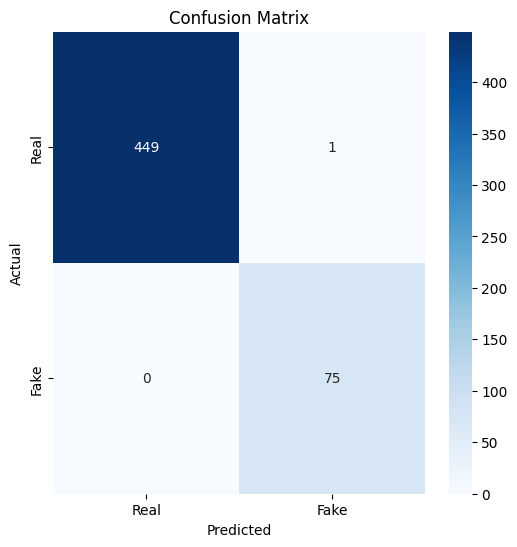

Visualizing attention for: /content/dataset/real/0_theo_44.wav


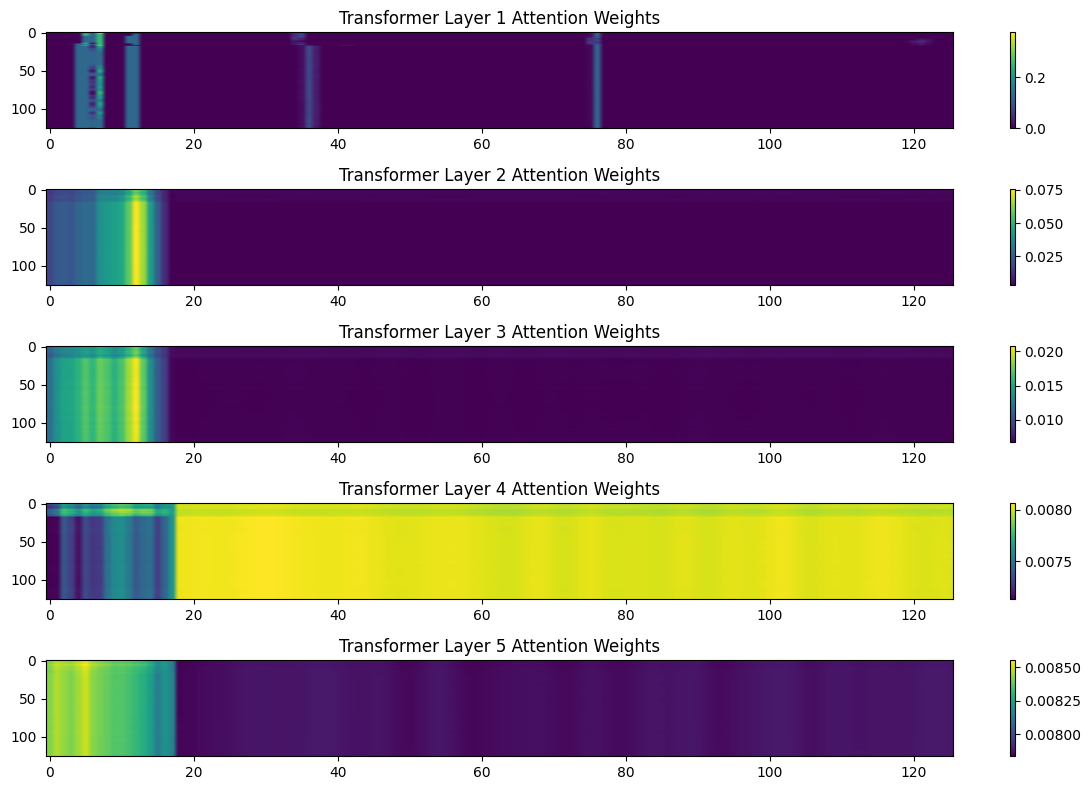

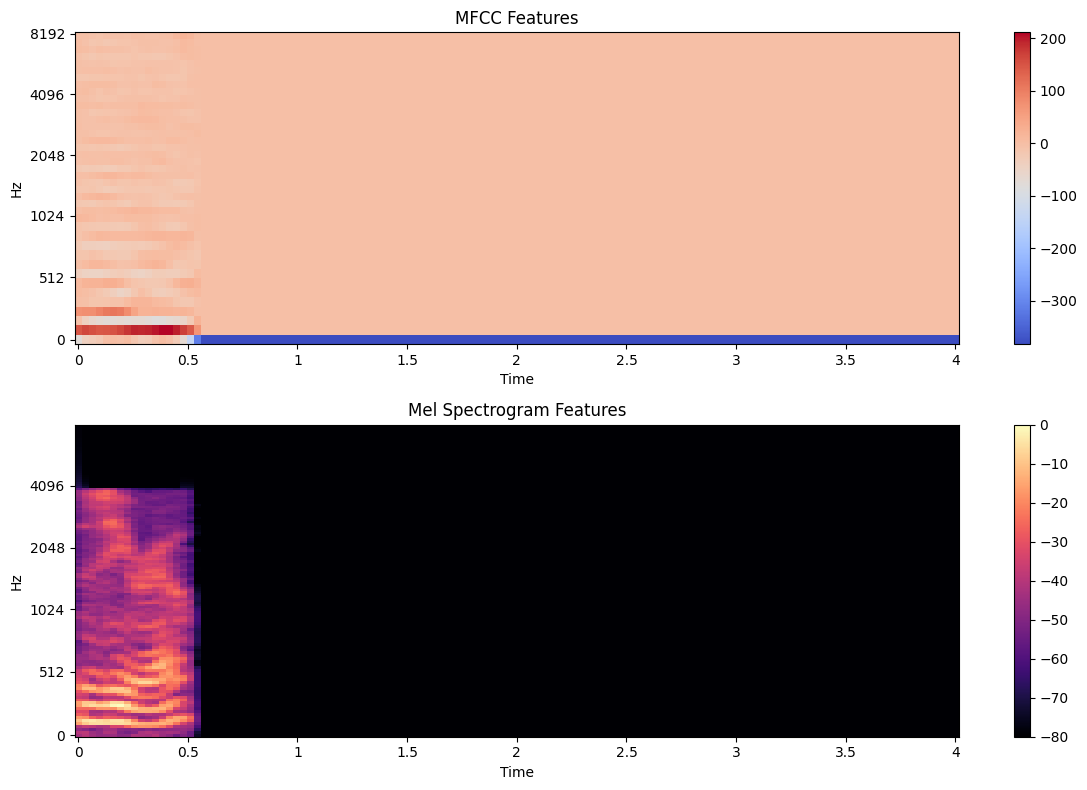

In [41]:
# Load dataset
dataset_dir = '/content/dataset'  # Update this path
file_paths, labels = load_dataset(dataset_dir)

# Split dataset
# The data is split into:
# - Training
# - Validation
# - Test
# Approximate final split ratio:
# - 70% Training
# - 15% Validation
# - 15% Test
# So, Training + Validation = 85%
########
# Training - The model learns from it.
# Validation - Used to calculate the model's accuracy during training (but does not affect it).
# Test - Used only after training to measure how well the model generalizes to entirely new data.

train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.15, random_state=1, stratify=labels
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1765, random_state=1, stratify=train_labels
)  # 0.1765 x 0.85 ≈ 0.15

print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")

# Initialize and train detector
detector = DeepfakeDetector(config)
history = detector.train(train_files, train_labels, val_files, val_labels)

# Evaluate on test set
detector.evaluate(test_files, test_labels)

# Visualize attention for a sample
sample_file = test_files[0]
print(f"Visualizing attention for: {sample_file}")
detector.visualize_attention(sample_file)

**Finally**, I will conduct a real experiment on the model and the weights I obtained on real audio files using my real voice.

Now i will try the pattern on my own voice when pronouncing **the number 1, the number 2, and the number 5.**

Test - Number 1

In [48]:
detector.predict_single_audio("/content/dataset/my voice/my_voice_1.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction: Real (Confidence: 0.00)


/tmp/ipython-input-26-393021506.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_label = int(prediction[0] > 0.5)
/tmp/ipython-input-26-393021506.py:213: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0])


(0, 4.478884277347994e-12)

In [47]:
detector.predict_single_audio("/content/dataset/my voice/my_voice_2.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: Fake (Confidence: 1.00)


/tmp/ipython-input-26-393021506.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_label = int(prediction[0] > 0.5)
/tmp/ipython-input-26-393021506.py:213: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0])


(1, 1.0)

In [51]:
detector.predict_single_audio("/content/dataset/real/0_george_22.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction: Real (Confidence: 0.00)


/tmp/ipython-input-26-393021506.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_label = int(prediction[0] > 0.5)
/tmp/ipython-input-26-393021506.py:213: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0])


(0, 3.728049119411381e-12)

In [52]:
detector.predict_single_audio("/content/dataset/fake/1_144.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Prediction: Fake (Confidence: 1.00)


/tmp/ipython-input-26-393021506.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_label = int(prediction[0] > 0.5)
/tmp/ipython-input-26-393021506.py:213: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(prediction[0])


(1, 1.0)